# Imports

In [1]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
from utils.model_utils import *
from utils.plot_utils import plot_stats
from utils.trainer import Trainer


# Dataloading

In [2]:
# Downloading and Loading Dataset
# Downloading and Loading Dataset
train_dataset = datasets.FashionMNIST(
    root='./data', train=True, transform=transforms.ToTensor(), download=True)

test_dataset = datasets.FashionMNIST(
    root='./data', train=False, transform=transforms.ToTensor())


In [3]:
# Fitting data loaders for iterating
B_SIZE = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=B_SIZE,
                                           shuffle=True,num_workers=8)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=B_SIZE,
                                          shuffle=False, num_workers=8)


# Visualization

In [4]:
label_dict = {
    0 :	'T-shirt/top',
    1 :	'Trouser',
    2 :	'Pullover',
    3:	'Dress',
    4:	'Coat',
    5:	'Sandal',
    6:	'Shirt',
    7:	'Sneaker',
    8:	'Bag',
    9:	'Ankle boot'
}





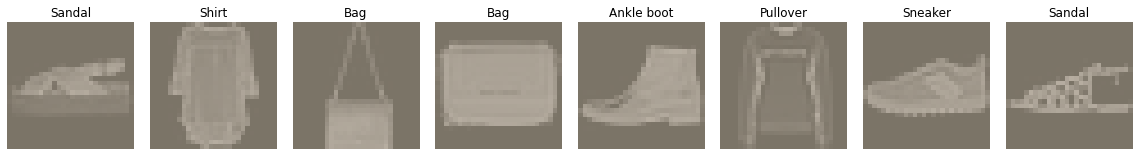

In [5]:
def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data = std * data + mean
    data = np.clip(data, 0, 1)

    plt.figure(figsize=(8*2, 4*2))
    for i in range(8):
        plt.subplot(4, 8, i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()


# Get a batch of training data and displaying it
image, label = next(iter(train_loader))

titles = [label_dict[x.item()] for x in label]

show_grid(image,titles=titles)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training

## LSTM Basic from Scratch

In [8]:
class LSTM_Homemade_Cell(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(LSTM_Homemade_Cell, self).__init__()
    self.input_length = input_size
    self.hidden_length = hidden_size
    
    self.x = nn.Linear(self.input_length, self.hidden_length, bias=True)
    self.h = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
    self.sigmoid_gate = nn.Sigmoid()
    self.activation_gate = nn.Tanh()

  def input_gate(self, x, h):
    return(self.sigmoid_gate((self.h(h))+(self.x(x))))

  def forget_gate(self, x, h):
    return(self.sigmoid_gate((self.h(h))+(self.x(x))))

  def update_gate(self, x, h, C_prev, i, f):
    
    x = self.x(x)
    h = self.h(h)
    C_cand = self.activation_gate(x+h)
    C = C_cand * i + C_prev * f
    return C

  def out_gate(self, x, h):
    x = self.x(x)
    h = self.h(h)
    return(self.sigmoid_gate(x+h))

  def forward(self, x, tuple_in):
    (h, c_prev) = tuple_in
    
    # Equation 1. input gate
    i = self.input_gate(x, h)
    
    # Equation 2. forget gate
    f = self.forget_gate(x, h)
    
    # Equation 3. updating the cell memory
    c_next = self.update_gate(x, h, c_prev,i,f)
    # Equation 4. calculate the main output gate
    o = self.out_gate(x, h)
    # Equation 5. produce next hidden output
    h_next = o * self.activation_gate(c_next)

    return h_next, c_next


### LSTM Model with LSTM from Scratch Cell

In [9]:
class LSTMHomemadeClassifer(nn.Module):

    def __init__(self,input_dim,hidden_dim,num_layers,emb_dim,num_classes,mode,device):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.mode = mode
        self.device = device
        self.encoder = nn.Linear(in_features=input_dim,out_features=emb_dim)

        lstms = []

        for i in range(num_layers):
            in_size = emb_dim if i == 0 else hidden_dim
            
            lstms.append(LSTM_Homemade_Cell(in_size,hidden_dim))
        
        self.lstm = nn.ModuleList(lstms)
        self.classifier = nn.Linear(in_features=hidden_dim,out_features=num_classes)

    def forward(self,x):

        b_size,n_channels,n_rows,n_cols = x.shape
        h,c = self.init_state(b_size=b_size,device=self.device)

        x_rowed = x.view(b_size,n_channels * n_rows,n_cols)
        embeddings = self.encoder(x_rowed)


        lstm_out = []

        for i in range(embeddings.shape[1]):
            lstm_input = embeddings[:,i,:]
            for j,lstm_cell in enumerate(self.lstm):

                h[j],c[j] = lstm_cell(lstm_input,(h[j],c[j]))
                lstm_input = h[j]
            lstm_out.append(lstm_input)
        
        lstm_out = torch.stack(lstm_out,dim=1)


        y = self.classifier(lstm_out[:,-1,:])


        return y


    def init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = [torch.zeros(b_size, self.hidden_dim).to(device)
                 for _ in range(self.num_layers)]
            c = [torch.zeros(b_size, self.hidden_dim).to(device)
                 for _ in range(self.num_layers)]
        elif(self.mode == "random"):
            h = [torch.zeros(b_size, self.hidden_dim).to(device)
                 for _ in range(self.num_layers)]
            c = [torch.zeros(b_size, self.hidden_dim).to(device)
                 for _ in range(self.num_layers)]
        return h, c




In [16]:
model = LSTMHomemadeClassifer(input_dim=28,hidden_dim=256,num_layers=3,emb_dim=64,num_classes=10,device=device,mode="zeros")
model = model.to(device)
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [17]:
model
count_model_params(model)

349258

In [18]:
train = Trainer(name = "LSTM_Homemade_2",model=model,epochs=30,train_loader=train_loader,eval_loader=test_loader,criterion=criterion,optimizer=optimizer,scheduler=scheduler,device=device,save_true=True,plot=True,save_freq=5,eval_freq=2)

Epoch 30 loss 0.30092. : 100%|██████████| 30/30 [39:44<00:00, 79.49s/it]


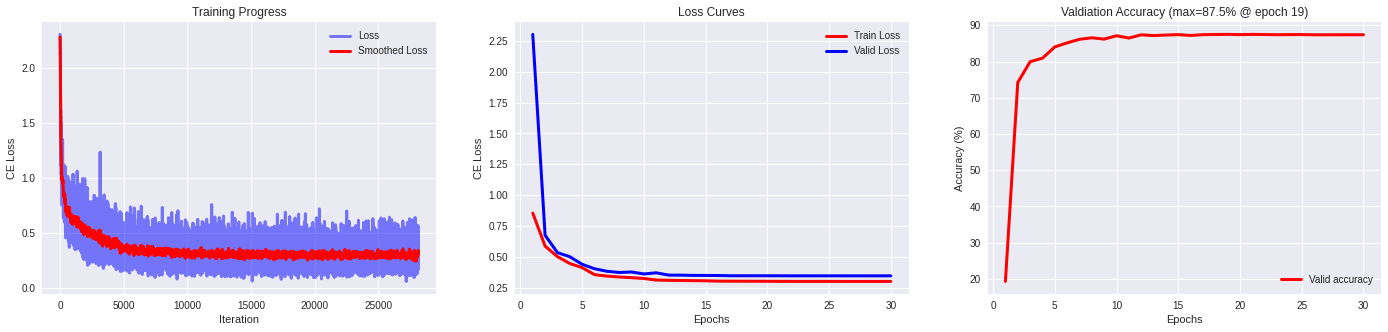

Training completed


In [19]:
train_loss, val_loss, loss_iters, valid_acc = train.train_model()

## LSTM Conv Cell from Scratch

In [10]:
class ConvLSTMHomemadeCell(nn.Module):
  def __init__(self, input_size, hidden_size,kernel_size):
    super(ConvLSTMHomemadeCell, self).__init__()
    self.input_length = input_size
    self.hidden_length = hidden_size
    padding = (kernel_size - 1) / 2
    self.x = nn.Conv2d(in_channels = self.input_length, out_channels = self.hidden_length, kernel_size=kernel_size,padding=int(padding),bias=True)
    self.h = nn.Conv2d(in_channels = self.hidden_length, out_channels =self.hidden_length, kernel_size = kernel_size,padding=int(padding),bias=False)
    self.sigmoid_gate = nn.Sigmoid()
    self.activation_gate = nn.Tanh()

  def input_gate(self, x, h):
    return(self.sigmoid_gate((self.h(h))+(self.x(x))))

  def forget_gate(self, x, h):
    return(self.sigmoid_gate((self.h(h))+(self.x(x))))

  def update_gate(self, x, h, C_prev, i, f):

    x = self.x(x)
    h = self.h(h)
    
    C_cand = self.activation_gate(x+h)
    C = C_cand * i + C_prev * f
    return C

  def out_gate(self, x, h):
    x = self.x(x)
    h = self.h(h)
    return(self.sigmoid_gate(x+h))

  def forward(self, x, tuple_in):
    (h, c_prev) = tuple_in
  
    # Equation 1. input gate
    i = self.input_gate(x, h)

    # Equation 2. forget gate
    f = self.forget_gate(x, h)

    # Equation 3. updating the cell memory
    c_next = self.update_gate(x, h, c_prev, i, f)
    # Equation 4. calculate the main output gate
    o = self.out_gate(x, h)
    # Equation 5. produce next hidden output
    h_next = o * self.activation_gate(c_next)

    return h_next, c_next


### LSTM Model with Conv LSTM

In [11]:
class ConvLSTMHomemadeClassifer(nn.Module):

    def __init__(self, channels, image_size,hidden_dim, num_layers, emb_dim, num_classes, mode, device):
        super().__init__()
        (h,w) = image_size
        self.hidden_dim = hidden_dim    
        self.num_layers = num_layers
        self.mode = mode
        self.device = device
        
        self.encoder = nn.Conv2d(in_channels=channels, out_channels=emb_dim,kernel_size=(3,3),padding=1)

        lstms = []

        for i in range(num_layers):
            in_size = channels if i == 0 else hidden_dim

            lstms.append(ConvLSTMHomemadeCell(input_size=in_size, hidden_size=hidden_dim,kernel_size=3))

        self.lstm = nn.ModuleList(lstms)
        self.classifier = nn.Linear(in_features=self.hidden_dim*h*w,out_features=num_classes)
        
        

    def forward(self, x):

        b_size, n_channels, n_rows, n_cols = x.shape
        h, c = self.init_state(b_size=b_size,height= n_rows,width= n_cols,device=self.device)

        embeddings = self.encoder(x)
    
        lstm_out = []

        for i in range(embeddings.shape[1]):
            lstm_input = embeddings[:, i, :, :].unsqueeze(1)
            
            for j, lstm_cell in enumerate(self.lstm):

                h[j], c[j] = lstm_cell(lstm_input, (h[j], c[j]))
                lstm_input = h[j]
            lstm_out.append(lstm_input)
        lstm_out = torch.stack(lstm_out, dim=1)
        
        out = lstm_out[:, -1:, :, :, :]
        out = out.squeeze(1).view(b_size, np.prod(lstm_out.shape[2:]))
        y = self.classifier(out)

        return y

    def init_state(self, b_size, height, width,device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = [torch.zeros(b_size, self.hidden_dim, height,width).to(device)
                 for _ in range(self.num_layers)]
            c = [torch.zeros(b_size, self.hidden_dim, height, width).to(device)
                 for _ in range(self.num_layers)]
        elif(self.mode == "random"):
            h = [torch.zeros(b_size, self.hidden_dim, height, width).to(device)
                 for _ in range(self.num_layers)]
            c = [torch.zeros(b_size, self.hidden_dim, height, width).to(device)
                 for _ in range(self.num_layers)]
        return h, c

In [12]:
model_conv = ConvLSTMHomemadeClassifer(channels=1, image_size = (28,28),hidden_dim=32, num_layers=1,
                              emb_dim=8, num_classes=10, device=device, mode="zeros")
model_conv = model_conv.to(device)
# classification loss function
criterion_conv = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_conv = torch.optim.Adam(model_conv.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler_conv = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=3, gamma=0.2)


In [13]:
model_conv

ConvLSTMHomemadeClassifer(
  (encoder): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lstm): ModuleList(
    (0): ConvLSTMHomemadeCell(
      (x): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (h): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (sigmoid_gate): Sigmoid()
      (activation_gate): Tanh()
    )
  )
  (classifier): Linear(in_features=25088, out_features=10, bias=True)
)

In [14]:
train_conv = Trainer(name = "Conv_LSTM_Homemade",model=model_conv,epochs=10,train_loader=train_loader,eval_loader=test_loader,criterion=criterion_conv,optimizer=optimizer_conv,scheduler=scheduler_conv,device=device,save_true=True,plot=True,save_freq=5,eval_freq=2)

Epoch 10 loss 0.10010. : 100%|██████████| 10/10 [26:18<00:00, 157.86s/it]


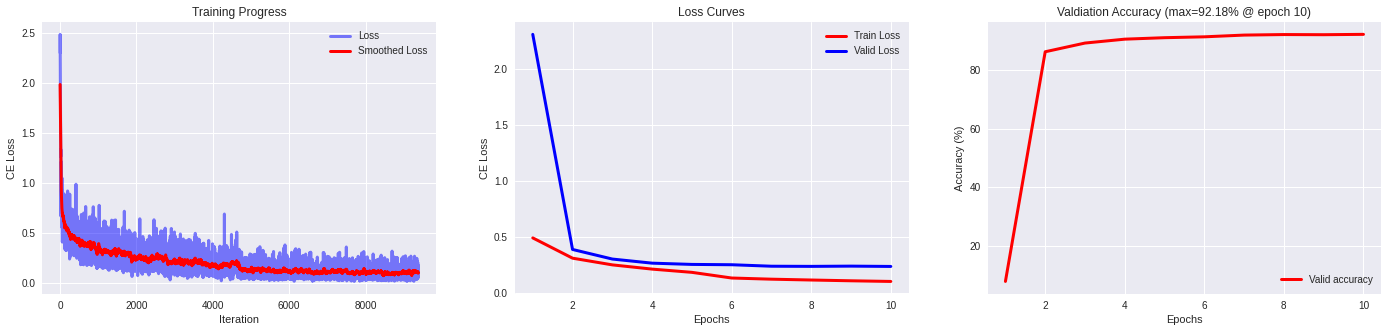

Training completed


In [15]:
train_loss_conv, val_loss_conv, loss_iters_conv, valid_acc_conv = train_conv.train_model()

## LSTM Pytorch

In [14]:
class LSTMClassifier(nn.Module):
    """ 
    Sequential classifier for images. Embedded image rows are fed to a RNN
    Same as above, but using LSTMCells instead of the LSTM object
    
    Args:
    -----
    input_dim: integer
        dimensionality of the rows to embed
    emb_dim: integer 
        dimensionality of the vectors fed to the LSTM
    hidden_dim: integer
        dimensionality of the states in the cell
    num_layers: integer
        number of stacked LSTMS
    mode: string
        intialization of the states
    """

    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers=1, mode="zeros"):
        """ Module initializer """
        assert mode in ["zeros", "random"]
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.mode = mode

        # for embedding rows into vector representations
        self.encoder = nn.Linear(in_features=input_dim, out_features=emb_dim)

        # LSTM model
        lstms = []
        for i in range(num_layers):
            in_size = emb_dim if i == 0 else hidden_dim
            lstms.append(nn.LSTMCell(
                input_size=in_size, hidden_size=hidden_dim))
        self.lstm = nn.ModuleList(lstms)

        # FC-classifier
        self.classifier = nn.Linear(in_features=hidden_dim, out_features=10)

        return

    def forward(self, x):
        """ Forward pass through model """

        b_size, n_channels, n_rows, n_cols = x.shape
        h, c = self.init_state(b_size=b_size, device=x.device)

        # embedding rows
        x_rowed = x.view(b_size, n_channels*n_rows, n_cols)
        embeddings = self.encoder(x_rowed)

        # iterating over sequence length
        lstm_out = []
        for i in range(embeddings.shape[1]):
            lstm_input = embeddings[:, i, :]
            # iterating over LSTM Cells
            for j, lstm_cell in enumerate(self.lstm):
                h[j], c[j] = lstm_cell(lstm_input, (h[j], c[j]))
                lstm_input = h[j]
            lstm_out.append(lstm_input)
        lstm_out = torch.stack(lstm_out, dim=1)

        # classifying
        # feeding only output at last layer
        y = self.classifier(lstm_out[:, -1, :])

        return y

    def init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = [torch.zeros(b_size, self.hidden_dim).to(device)
                 for _ in range(self.num_layers)]
            c = [torch.zeros(b_size, self.hidden_dim).to(device)
                 for _ in range(self.num_layers)]
        elif(self.mode == "random"):
            h = [torch.zeros(b_size, self.hidden_dim).to(device)
                 for _ in range(self.num_layers)]
            c = [torch.zeros(b_size, self.hidden_dim).to(device)
                 for _ in range(self.num_layers)]
        return h, c


In [15]:
model_pytorch = LSTMClassifier(input_dim=28, emb_dim=28, hidden_dim=128, num_layers=2, mode="random")
model_pytorch.to(device)
# classification loss function
criterion_pytorch = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_pytorch = torch.optim.Adam(model_pytorch.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler_pytorch = torch.optim.lr_scheduler.StepLR(optimizer_pytorch, step_size=5, gamma=0.2)


In [12]:
train_pytorch = Trainer(name = "LSTM_Pytorch",model=model_pytorch,epochs=15,train_loader=train_loader,eval_loader=test_loader,criterion=criterion_pytorch,optimizer=optimizer_pytorch,scheduler=scheduler_pytorch,device=device,save_true=True,plot=True,save_freq=5,eval_freq=2)

Epoch 15 loss 0.30826. : 100%|██████████| 15/15 [04:44<00:00, 18.98s/it]


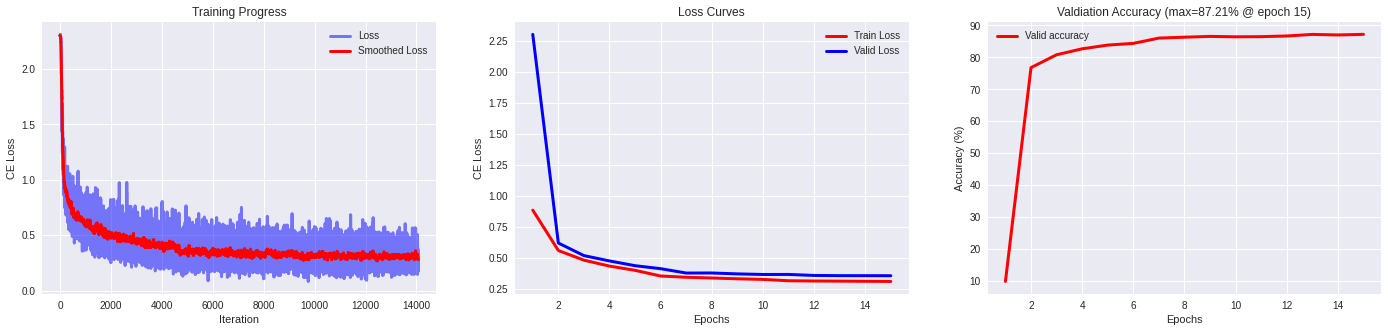

Training completed


In [13]:
train_loss_pytorch, val_loss_pytorch, loss_iters_pytorch, valid_acc_pytorch = train_pytorch.train_model()


# Testing

## LSTM Homemade

In [16]:
model = LSTMHomemadeClassifer(input_dim=28, hidden_dim=256, num_layers=3,
                              emb_dim=64, num_classes=10, device=device, mode="zeros")
model = model.to(device)
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)


#Loding pretrained Network

model,optimizer=load_model(
    model=model, optimizer=optimizer, savepath='/home/dhagash/MS-GE-03/CudaVision/assignment-5/models/LSTM_Homemade_2/best_model.pth',plot = False
)


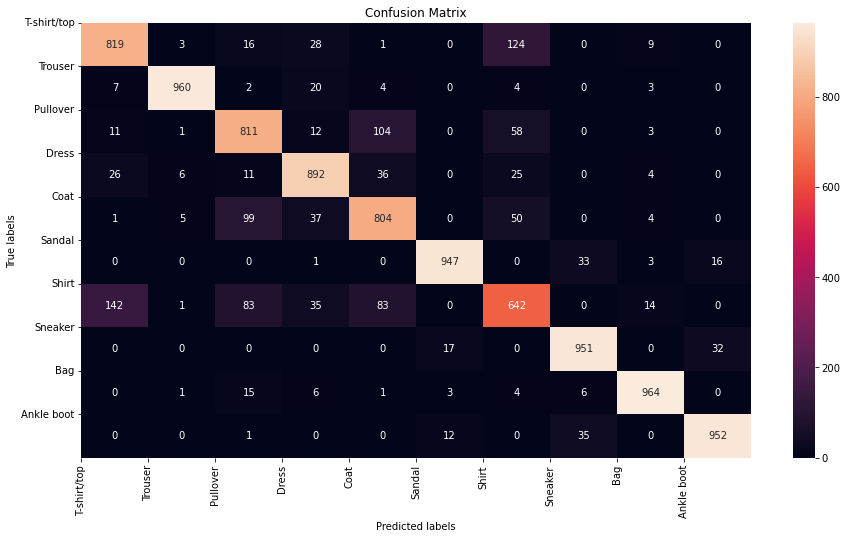

Accuracy of our implementation of LSTM Cell is 87.42%


In [26]:
accuracy_lstm = test_model(model=model,test_loader=test_loader,device=device,plot_cm=True,label_dict=label_dict)
print(f"Accuracy of our implementation of LSTM Cell is {round(accuracy_lstm,2)}%")

## LSTM Pytorch

In [20]:
model_pytorch = LSTMClassifier(
    input_dim=28, emb_dim=28, hidden_dim=128, num_layers=2, mode="random")
model_pytorch.to(device)
# classification loss function
criterion_pytorch = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_pytorch = torch.optim.Adam(model_pytorch.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler_pytorch = torch.optim.lr_scheduler.StepLR(
    optimizer_pytorch, step_size=5, gamma=0.2)

model_pytorch, optimizer_pytorch = load_model(
    model=model_pytorch, optimizer=optimizer_pytorch, savepath='/home/dhagash/MS-GE-03/CudaVision/assignment-5/models/LSTM_Pytorch/best_model.pth', plot=False
)


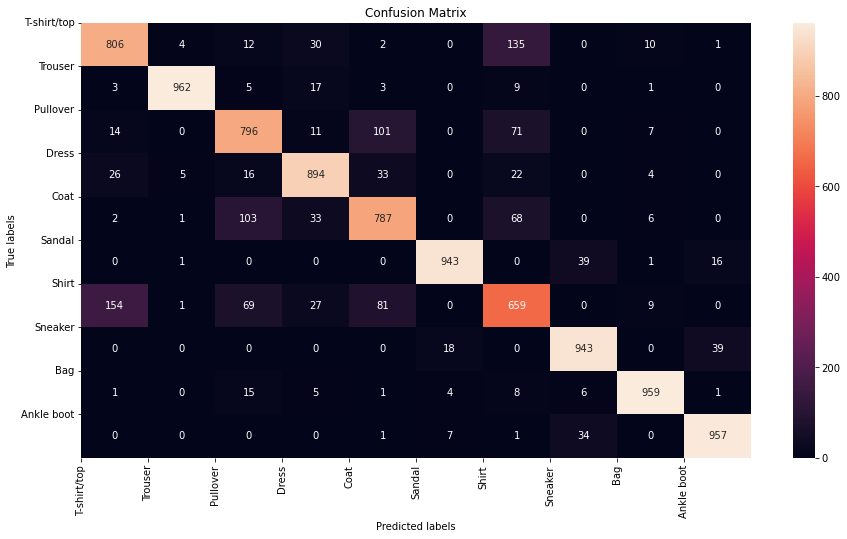

Accuracy of LSTM Cell Pytorch implementation is 87.06%


In [27]:
accuracy_pytorch = test_model(model=model_pytorch, test_loader=test_loader,
                           device=device, plot_cm=True, label_dict=label_dict)
print(f"Accuracy of LSTM Cell Pytorch implementation is {round(accuracy_pytorch,2)}%")


## Conv LSTM Homemade

In [24]:
model_conv = ConvLSTMHomemadeClassifer(channels=1, image_size=(28, 28), hidden_dim=64, num_layers=1,
                                       emb_dim=16, num_classes=10, device=device, mode="zeros")
model_conv = model_conv.to(device)
# classification loss function
criterion_conv = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_conv = torch.optim.Adam(model_conv.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler_conv = torch.optim.lr_scheduler.StepLR(
    optimizer_conv, step_size=3, gamma=0.2)

model_conv, optimizer_conv = load_model(
    model=model_conv, optimizer=optimizer_conv, savepath='/home/dhagash/MS-GE-03/CudaVision/assignment-5/models/Conv_LSTM_Homemade/best_model.pth', plot=False
)


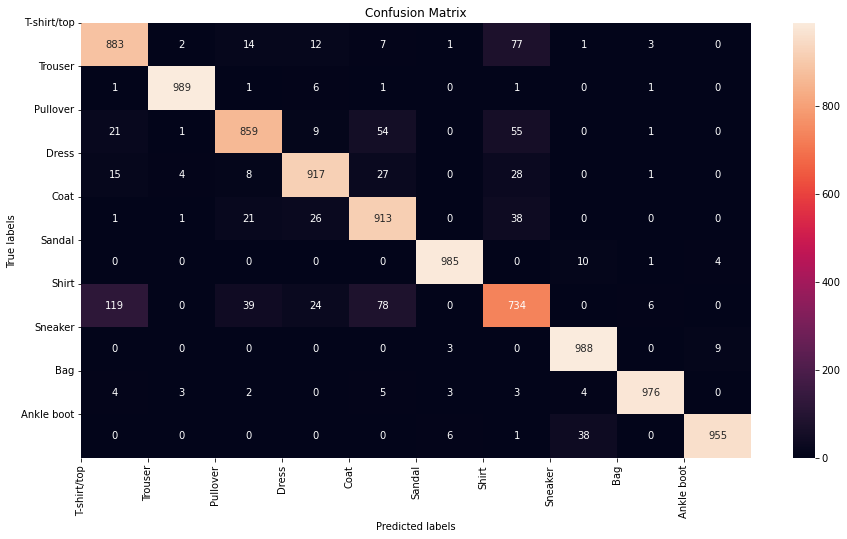

Accuracy of our implementation of ConvLSTM is 91.99%


In [28]:
accuracy_conv = test_model(model=model_conv, test_loader=test_loader,
                              device=device, plot_cm=True, label_dict=label_dict)
print(f"Accuracy of our implementation of ConvLSTM is {round(accuracy_conv,2)}%")


# Results (Comments)

## Most Confused Category

- Naturally most confused category is shirt as it is similar to tshirt/top,pullover,coat

## Training and Accuracy

- Our implementation of LSTM Cell and Pytorch version have comparable accuracies overall meaning no gross errors in our code, although the parameters of both classifiers are slightly different
- ConvLSTM performs the best with accuracy of 91.99% given that its just predicting that by sequence input of channels with just one RNN unit is incredible

## Open Questions

- Does data augmentation help in RNN classification?  We are not able to think if it will help
- What about data size while training RNN for video sequence etc does it require quite good amount of data to generalize? If we dont have sufficient data which techniques are there to enlarge dataset in this case?